# CTXCTL-USERS 

Before starting, make sure you have [rpyc](https://rpyc.readthedocs.io/en/latest/install.html) installed.

## Getting Started:

### 1. Open the `cortexcontrol` gui: 

In [ ]:
import os
os.chdir('../../cortexcontrol/')
os.system('./cortexcontrol&')
os.chdir('..')

### 2. Start the rpyc server:


Start the rpyc server by copying in the ctxctl console:
    
`import run_rpyc`

You are ready to run this tutorial in the jupyter notebook.

### 3. Create a **`CtxctlController`** object

In [3]:
from ctxctl_contrib.CtxctlController import CtxctlController

CC = CtxctlController(backend='rpyc', verbose=True)

CtxctlController : __init__()
Rpyc : Creating connection to host
Rpyc : ..done!
Rpyc : Setting rpyc timeout to 600  sec
CtxctlController : Reset
CtxctlController : Clearing CAMs..
CtxctlController : done!
CtxctlController : Clearing SRAMs..
CtxctlController : done!
CtxctlFPGA : __init__()
CtxctlCalib : __init__()
CtxcctlConnector : __init__()
CtxctlController : Ctxctl initialized!


**NOTE** If without `rpyc`, replace it with : `CC = CtxctlController(backend='ctxctl', verbose=True)`

This creates the objects **`Connector`**, **`FPGAController`** and **`Calibrator`** that wrap some low-level functionalities of the [CTXCTL Python API](http://ai-ctx.gitlab.io/ctxctl/primer.html#python-api)

In [4]:
Connector = CC.connector
FPGAController = CC.fpga
Calibrator = CC.calibrator

Here are some examples that show how to use these objects.

## Calibrator:
This class implements the following main functionalities:
* load biases
* save biases
* silence 'hot' neuron ids
* get f-f curves (as a function of biases)

#### Loading biases:
Set path to folder with biases and load bias file

In [5]:
Calibrator.set_path_bias('./ctxctl_contrib/')

In [6]:
Calibrator.load_biases('example_biases.py')

CtxctlCalib : Biases loaded form example_biases.py


## Connector: 

This class implements the following functionalities:
* create connections
* remove connections
* get neuron cams/ srams
* check for cam clash
* store lookuptable of created **onchip** connections

#### Connect neurons on chip : `connection_type='onchip'`

Create two lists of pre and post neuron ids with fast excitatory synapses:

In [7]:
pre = list(range(1,256))
post = list(range(257, 512))
Connector.connect(pre, post, 
                  syn_type=CC.SynType.FAST_EXC, 
                  syn_weight=1, 
                  connection_type='onchip', 
                  name='MyOnchip_connection', 
                  verbose=True)

CtxcctlConnector : creating connection MyOnchip_connection
CtxcctlConnector : Onchip connection created!


Check synapse weight between neuron 1 and 257:

In [8]:
Connector.weights_lookup[(1, 257)]

('MyOnchip_connection', 1)

#### Connect neurons to FPGA virtual neurons : `connection_type='virtual'`

Create two lists of pre and post neuron ids with fast excitatory synapses. This time the pre neurons will be
**virtual** neurons (i.e. neurons on FPGA)

In [9]:
pre_virtual = list(range(257, 512))
post_virtual = list(range(1,256))
Connector.connect(pre_virtual, post_virtual, 
                  syn_type=CC.SynType.FAST_EXC, 
                  syn_weight=1, 
                  connection_type='virtual', 
                  name='MyVirtual_connection', 
                  verbose=True)

CtxcctlConnector : creating connection MyVirtual_connection
CtxcctlConnector : Virtual connection created!


#### Monitoring the connections state:

* Are neuron 1 and 257 connected? How many CAMs are between them?

In [10]:
Connector.weights_lookup[(1, 257)]

('MyOnchip_connection', 1)

* What are the pairs of pre post neuron of synapse type '`MyVirtual_connection'' ?

In [11]:
pre, post = Connector.synapse_lookup['MyOnchip_connection']

* How many CAMs of neuron 257 are currently set?

In [12]:
Connector.num_cams_used[257]

1

#### Remove connections onchip:

In [13]:
pre = list(range(1,256))
post = list(range(257, 512))
Connector.remove_connection(pre, post)

CtxcctlConnector : Connection removed!


Check connection state. The conection between neuron 1 and 257 has been now removed. This is why the next line raises a `KeyError`

In [14]:
Connector.weights_lookup[(1, 257)]

KeyError: (1, 257)

As well as the next one, since all connections in 'MyOnchip_connection' have been removed

In [15]:
Connector.synapse_lookup['MyOnchip_connection']

KeyError: 'MyOnchip_connection'

And the total number of used CAMs of neuron 257 is now zero.

In [16]:
Connector.num_cams_used[257]

0

## FPGAController: 

### SpikeGenerator
First, create a virtual connection. We have already created `MyVirtual_connection` in our example.
Now let's define some input parameters for the SpikeGenerator:
* `spike_times`: list of spike times
* `neuron_ids`: list of neuron ids pre of the SpikeGenerator, sorted according to the time of spike
* `target_chips`: list of target chip ids, one for each element of the neuron id
* `isi_base`: integer for the ctxctl `isi_multiplier`

We will now set a SpikeGenerator for the first 16 `virtual` neurons of `MyVirtual_connection`

In [17]:
import numpy as np

spike_times = np.linspace(0, 3, 16)
neuron_ids = pre_virtual[0:16]
# In our example all neurons post in `MyVirtual_connection` are in chip 0
target_chips = [0]*len(neuron_ids)
isi_base = 900

* Now we can set the **SpikeGenerator**

In [18]:
FPGAController.set_spikeGen(spike_times, neuron_ids, target_chips, isi_base)

CtxctlFPGA : FpgaSpikeGen set
    To start: self.spikeGen.start()
    To stop: self.spikeGen.stop()


* To start the stimulus:

In [19]:
FPGAController.spikeGen.start()

You should see the first 16 neurons in core zero firing one by one..

### Poisson SpikeGenerator:

Let's create a Poisson SpikeGenerator consisting of 10 `virtual` neurons firing at 50 Hz and targeting the neuron post of `MyVirtual_connection`:
* `poisson_rates_hz`: list of Poisson input rates
* `neuron_ids`: list of neuron ids pre of the PoissonSpikeGenerator, one for each Poisson mean firing rate
* `target_chip`: chip id of the targeted population.

In [20]:
n_input_neurons = 10
poisson_rates_hz = [50]*n_input_neurons
neuron_ids = pre_virtual[20:20+10]
target_chip = 0 # neurons post are in chip 0 in `MyVirtual_connection`

* Now we can set the PoissonSpikeGenerator:

In [21]:
FPGAController.set_poissGen(poisson_rates_hz, neuron_ids, target_chip)

CtxctlFPGA : PoissonGen set
CtxctlFPGA : To start: self.poissGen.start()
CtxctlFPGA : To start: self.poissGen.stop()


* To start the stimulus:

In [42]:
FPGAController.poissGen.start()

You should see 10 neurons in core zero firing. To stop it:

In [43]:
FPGAController.poissGen.stop()

### Examples:

#### 1. Using Poisson SpikeGenerator to get f-f curves. 
* Frist connect neurons in core 2 to `virtual` neurons

In [46]:
# Connect neurons to input neurons on FPGA with one to one connections        
nrn_id_fpga = np.arange(512,512+256) 
pre = list(nrn_id_fpga)
post = list(nrn_id_fpga)
min_freq = 20
max_freq = 500
list_input_frequencies = list(np.linspace(min_freq, max_freq, len(pre)))

# Connect neurons
Connector.connect(pre, 
                     post, 
                     syn_type=CC.SynType.FAST_EXC, 
                     syn_weight=1, 
                     connection_type='virtual', 
                     name='MyVirtualConnection2')   

CtxcctlConnector : Virtual connection created!


* Then get f-f curve using the `Calibrator` object:

In [ ]:
Calibrator.path_rec='./ctxctl_contrib/'
Calibrator.ff_curve(pre, 
                    post, 
                    list_input_frequencies)

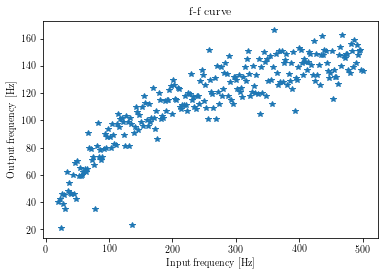

In [54]:
import matplotlib.pyplot as plt
array_rates = np.loadtxt(Calibrator.path_rec+str(Calibrator.creation_time) + '_ffcurve_.txt')
plt.figure()
plt.plot(list_input_frequencies, array_rates, '*')
plt.xlabel('Input frequency [Hz]')
plt.ylabel('Output frequency [Hz]')
plt.title('f-f curve')
plt.show()